# Wind Turbine Scada Dataset
## 2018 Scada Data of a Wind Turbine in Turkey

**Context**
In Wind Turbines, Scada Systems measure and save data's like wind speed, wind direction, generated power etc. for 10 minutes intervals. This file was taken from a wind turbine's scada system that is working and generating power in Turkey.

**Content**
The data's in the file are:

* **Date/Time** (for 10 minutes intervals)
* **LV ActivePower (kW)**: The power generated by the turbine for that moment
* **Wind Speed (m/s)**: The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)
* **TheoreticalPowerCurve (KWh)**: The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
* **Wind Direction (°)**: The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)

## Content:

1. Import Packages
2. Read Dataset
3. Data preparation
    * 3.1. Remove Outliers
    * 3.2. Missing values
    * 4.1 Convert types
4. Exploratory data analysis
    * 4.1 Correlation matrix
    * 4.2 Feature engineering
        * 4.2.1 Date/Time
        * 4.2.2 LV ActivePower (kW)
        * 4.2.3 Wind Speed (m/s)
        * 4.2.4 TheoreticalPowerCurve (KWh)
        * 4.2.5 Wind Direction (°)

## 1. Import packages

In [1]:
# Imports

import os
import numpy as np
import pandas as pd

from scipy.stats import skew, norm

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

mycols = sns.hls_palette(10, h=.5)
sns.set_palette(palette = mycols)

from scipy.stats.stats import pearsonr

from windrose import WindroseAxes

import datetime
import time

## 2. Read Dataset

In [2]:
# Read csv
print(os.listdir('../WindTurbine/data'))
wt_data = pd.read_csv('../WindTurbine/data/T1.csv', parse_dates=True)

['T1.csv']


## 3. Data preparation

In [3]:
wt_data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


**Rename columns**

In [4]:
wt_data.rename(columns={'LV ActivePower (kW)':'LVA_Power',"Wind Speed (m/s)":"WindSpeed",
                        "Wind Direction (°)":"Wind_Direction", 'Date/Time':'DateTime', 
                       'Theoretical_Power_Curve (KWh)':'TPC_KWh'}, inplace=True)
wt_data.head()

,DateTime,LVA_Power,WindSpeed,TPC_KWh,Wind_Direction
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [5]:
wt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DateTime        50530 non-null  object 
 1   LVA_Power       50530 non-null  float64
 2   WindSpeed       50530 non-null  float64
 3   TPC_KWh         50530 non-null  float64
 4   Wind_Direction  50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


### 3.1. Outliers

* As we can see when comparing the maximum and minimum values with the average, there are no outliers in the data provided.

In [6]:
wt_data.describe()

,LVA_Power,WindSpeed,TPC_KWh,Wind_Direction
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


### 3.2. Missing values

In [7]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df, print_info = False):
        # Total missing values
        mis_val = df.isnull().sum()        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
                                      mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
        if print_info:
            # Print some summary information
            print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
                "There are " + str(mis_val_table_ren_columns.shape[0]) +  " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [8]:
missing_values_table(wt_data, True)

Your selected dataframe has 5 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### 3.3 Convert types

This will help reduce memory usage by using more efficient types for the variables:
* object - DateTime
* float64 - float32

In [9]:
wt_data['DateTime'] = pd.to_datetime(wt_data['DateTime'], format=('%d %m %Y %H:%M'))
wt_data['LVA_Power'] = wt_data['LVA_Power'].astype(np.float32)
wt_data['WindSpeed'] = wt_data['WindSpeed'].astype(np.float32)
wt_data['TPC_KWh'] = wt_data['TPC_KWh'].astype(np.float32)
wt_data['Wind_Direction'] = wt_data['Wind_Direction'].astype(np.float32)

## 4. Exploratory data analysis

### 4.1 Correlation matrix
* As expected, there is a high correlation between wind speed and the energy produced by the turbine.

Text(0.5, 1.05, 'Pearson Correlation of Features')

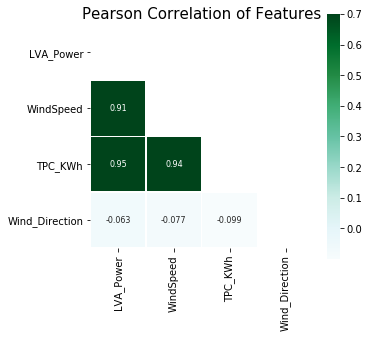

In [10]:
mask = np.zeros_like(wt_data.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(5,5))
    
sns.heatmap(wt_data.corr(),linewidths=0.25, vmax=0.7,square=True, cmap="BuGn", linecolor='w',
            annot=True,annot_kws={"size":8}, mask=mask,cbar_kws={"shrink": .9});
#"BuGn_r" to reverse 
plt.title('Pearson Correlation of Features', y=1.05, size=15)

As there is a high correlation between the columns wind speed, theoretical power curve: the higher the wind speed, the more power generated. In the same way it is related to the theoretical power curve.

Although given the low number of characteristics we can not rule out any.

### 4.2 Feature engieneering

#### 4.2.1 Date/Time
* We created a new dataframe using the date as an index
* Create new columns and convert to categorical data:
    * Month and convert to categorical data
    * Day
    
Note: we did not create the year column as the dataset only reflects data from 2018, and therefore it is not relevant.

In [11]:
wt_data.head()

,DateTime,LVA_Power,WindSpeed,TPC_KWh,Wind_Direction
0,2018-01-01 00:00:00,380.047791,5.311336,416.328918,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917542,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900024,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127563,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [12]:
ts = wt_data.set_index('DateTime')

In [13]:
ts_hour = ts.resample('H').mean().fillna(0)

In [14]:
ts_hour['month'] = ts_hour.index.strftime('%B')

In [15]:
ts_hour['month'] = pd.Categorical(ts_hour['month'], ordered = True)

In [16]:
ts_hour.head()

,LVA_Power,WindSpeed,TPC_KWh,Wind_Direction,month
DateTime,,,,,
2018-01-01 00:00:00,390.480347,5.506868,472.402222,267.118622,January
2018-01-01 01:00:00,460.537109,5.644205,513.418396,258.945557,January
2018-01-01 02:00:00,733.655396,6.452037,788.401306,268.397461,January
2018-01-01 03:00:00,909.362061,6.811455,948.793335,256.014771,January
2018-01-01 04:00:00,1393.518188,7.748749,1406.391846,247.652466,January


#### 4.2.2 LV ActivePower (kW)

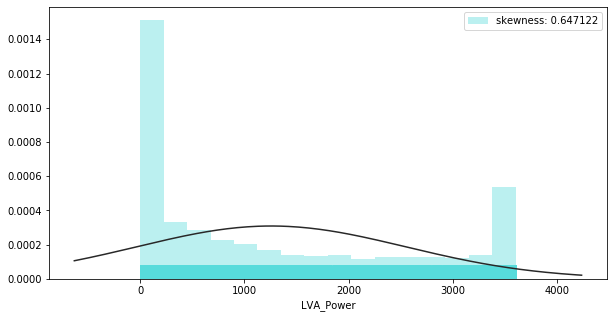

In [17]:
plt.subplots(figsize=(10,5))
d = sns.distplot(ts_hour['LVA_Power'], fit=norm, rug=True, kde=False,
                 label='skewness: %2f'%(ts_hour['LVA_Power'].skew()))
d = d.legend(loc='best')

In [18]:
'''ts_hour['LVA_Power'] = np.log1p(ts_hour['LVA_Power'])

plt.subplots(figsize=(10,5))
plt.title('AvtivePowe(kW)')
g = sns.distplot(ts_hour['LVA_Power'], fit=norm, kde=False, rug=True,
                 label='Skewness: %.2f'%(ts_hour['LVA_Power'].skew()));
g = g.legend(loc='best')'''

"ts_hour['LVA_Power'] = np.log1p(ts_hour['LVA_Power'])\n\nplt.subplots(figsize=(10,5))\nplt.title('AvtivePowe(kW)')\ng = sns.distplot(ts_hour['LVA_Power'], fit=norm, kde=False, rug=True,\n                 label='Skewness: %.2f'%(ts_hour['LVA_Power'].skew()));\ng = g.legend(loc='best')"

In [19]:
ts_hour.nunique()

LVA_Power         7032
WindSpeed         8436
TPC_KWh           7013
Wind_Direction    8435
month               12
dtype: int64

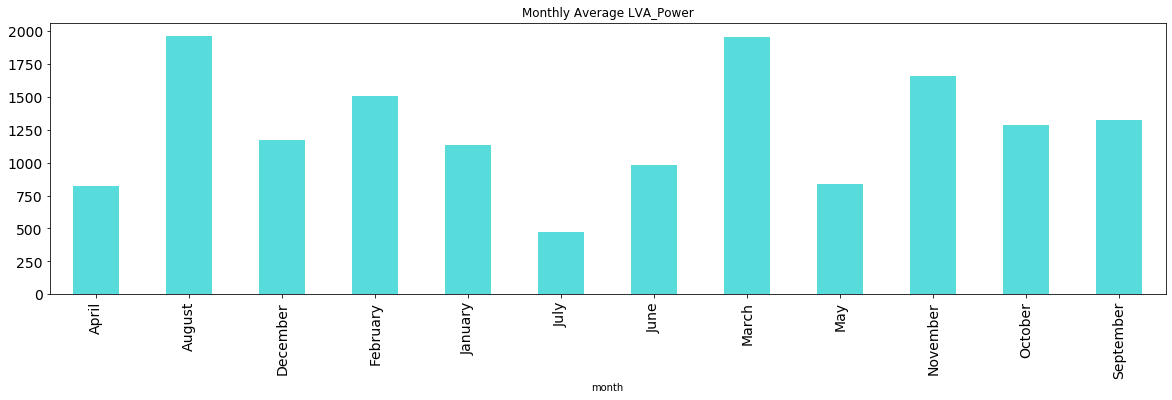

In [20]:
ts_hour.groupby('month')['LVA_Power'].mean().plot.bar(figsize = (20,5),
                                                      title = 'Monthly Average LVA_Power',
                                                      fontsize = 14)

### 4.2.3 Wind Speed (m/s)

In [21]:
ts_hour['WindSpeed'].nunique()

8436

In [22]:
'''
# function to round wind speed nearest 0.5
def round_sp(speed):
    return round(speed * 2) / 2'''

'\n# function to round wind speed nearest 0.5\ndef round_sp(speed):\n    return round(speed * 2) / 2'

In [23]:
#ts_hour['WindSpeed']=ts_hour['WindSpeed'].apply(round_sp)

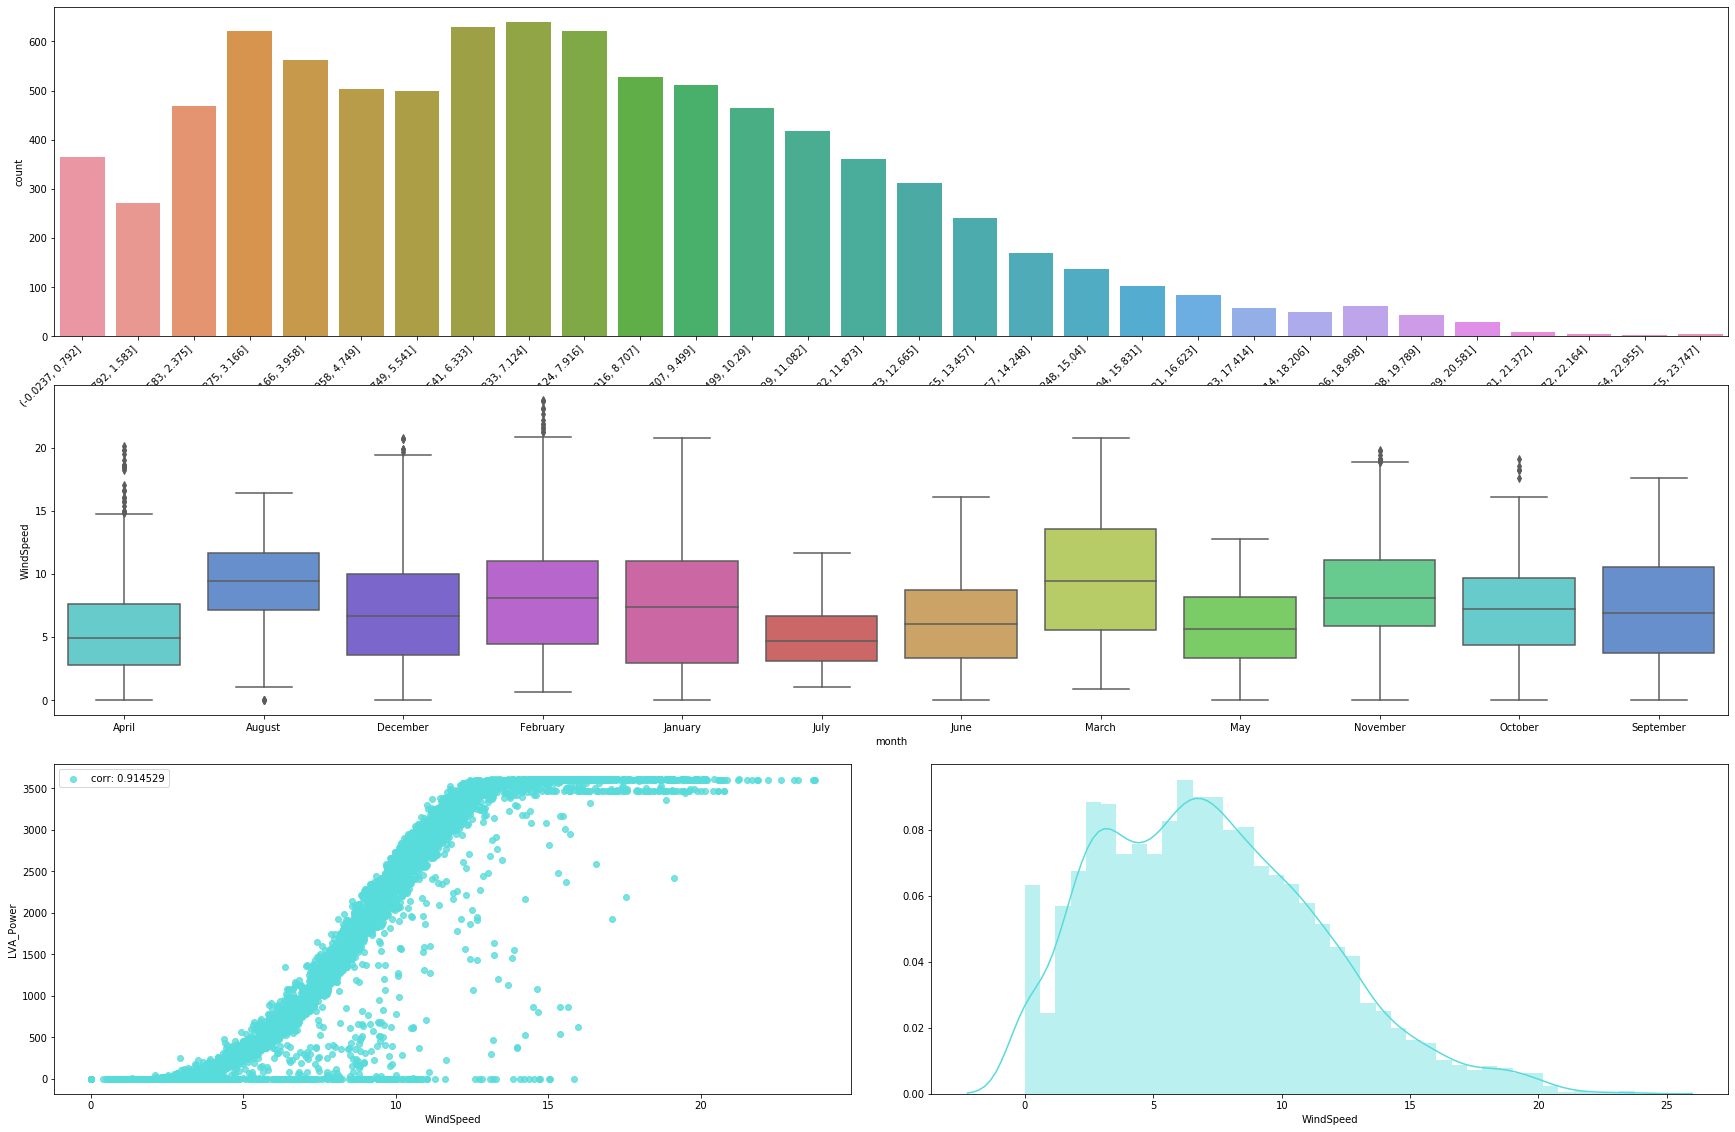

In [24]:
grid = plt.GridSpec(3, 2, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 20))

plt.subplot(grid[0, 0:])
sns.countplot(pd.cut(ts_hour['WindSpeed'], 30))
plt.xticks(rotation=45, horizontalalignment='right')

plt.subplot(grid[1, 0:])
sns.boxplot(x="month", y="WindSpeed", data=ts_hour, palette = mycols)

plt.subplot(grid[2, 0])
g = sns.regplot(x='WindSpeed', y='LVA_Power', data=ts_hour, fit_reg=False, 
                label = "corr: %2f"%(pearsonr(ts_hour['WindSpeed'], ts_hour['LVA_Power'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[2, 1]);
sns.distplot(ts_hour['WindSpeed'])

In [25]:
ts_hour['WindSpeed'].nunique()

8436

### 4.2.4 TheoreticalPowerCurve (KWh)

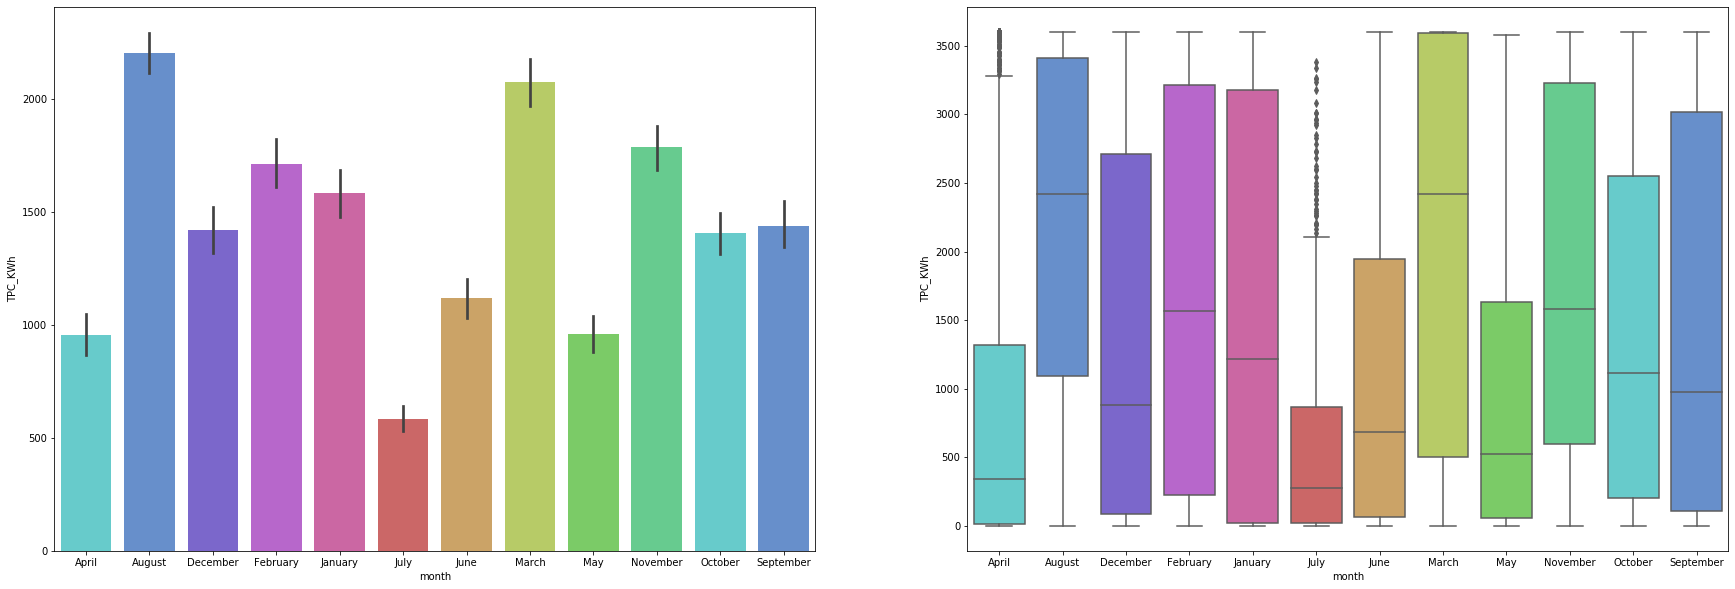

In [26]:
#cut_speed = ts_hour.groupby(pd.qcut(ts_hour['WindSpeed'], q = 25)).mean()

plt.subplots(figsize =(30,10))

plt.subplot(1,2,1)
sns.barplot(x="month", y="TPC_KWh", data=ts_hour, palette = mycols)

plt.subplot(1,2,2)
sns.boxplot(x="month", y="TPC_KWh", data=ts_hour, palette = mycols)

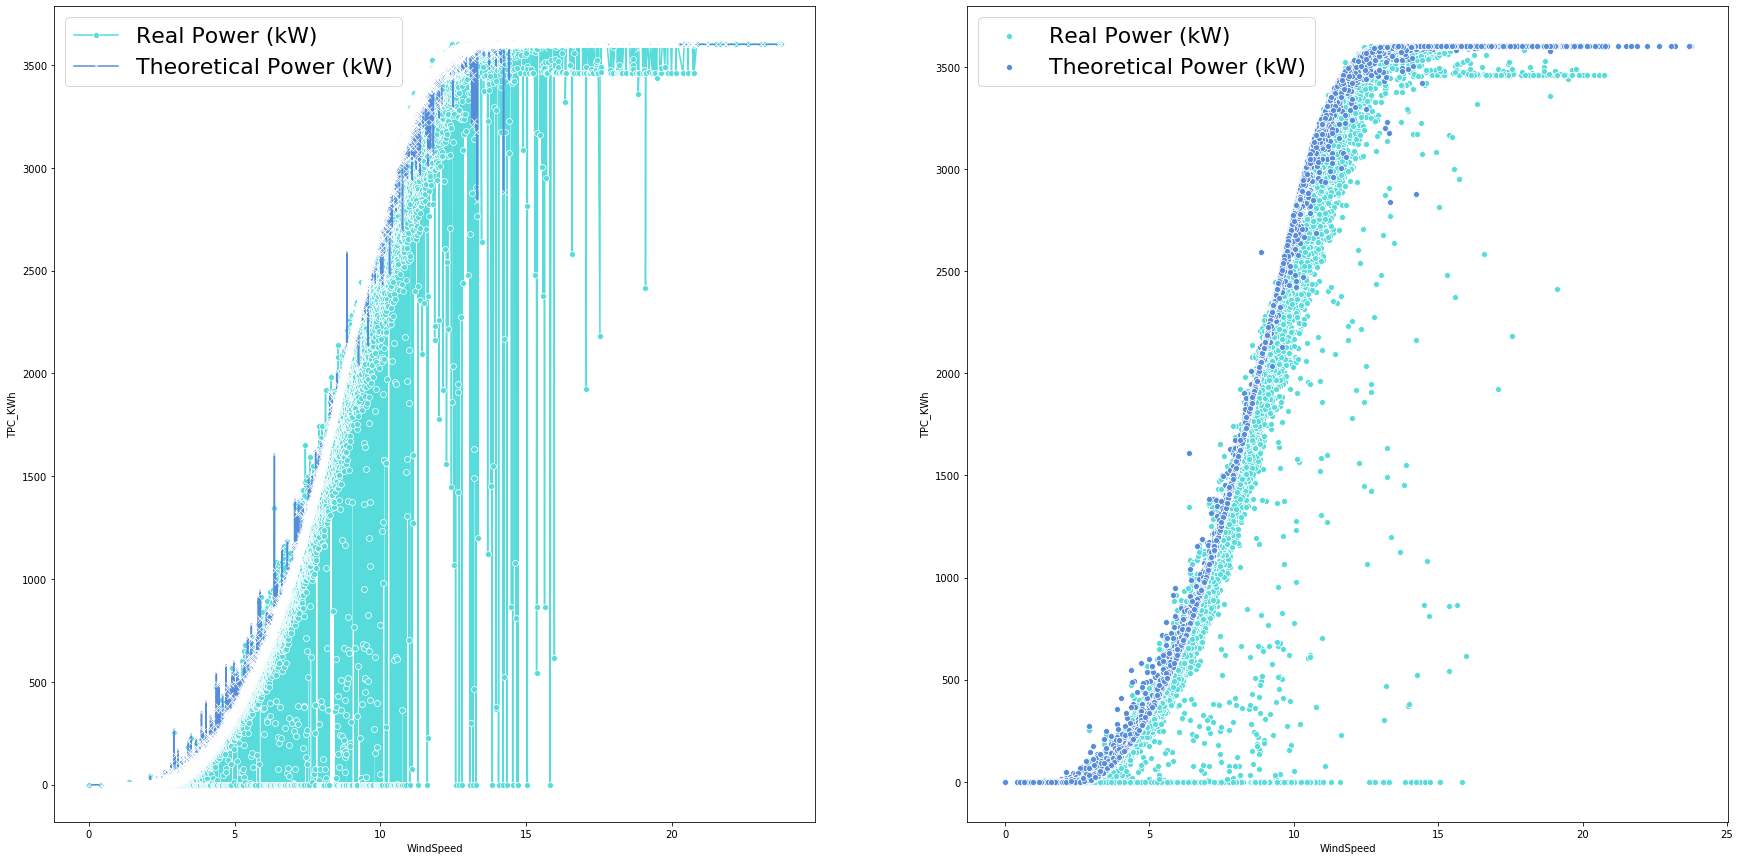

In [27]:
plt.subplots(figsize =(30,15))
#fig, ax = plt.subplots(1,2, figsize = (15,7.5))

plt.subplot(1,2,1)
#sns.scatterplot(x='WindSpeed', y='LVA_Power', data=ts_hour)
g = sns.lineplot(x = 'WindSpeed', y = 'LVA_Power', data = ts_hour, label = 'Real Power (kW)', marker = 'o')
g = sns.lineplot(x = 'WindSpeed', y = 'TPC_KWh', data = ts_hour, label = 'Theoretical Power (kW)', marker = 'x')
g.legend(loc="best", fontsize='22')

plt.subplot(1,2,2)
#sns.scatterplot(x='WindSpeed', y='TPC_KWh', data=ts_hour)

g = sns.scatterplot(x = 'WindSpeed', y = 'LVA_Power', data = ts_hour, label = 'Real Power (kW)')
g = sns.scatterplot(x = 'WindSpeed', y = 'TPC_KWh', data = ts_hour, label = 'Theoretical Power (kW)')
g.legend(loc="best", fontsize='22')

### 4.2.4 Wind Direction (°)

In [28]:
def degToCompass(num):
    val=int((num/22.5)+.5)
    arr=["N","NNE","NE","ENE","E","ESE", "SE", "SSE",
         "S","SSW","SW","WSW","W","WNW","NW","NNW"]
    return arr[(val % 16)]

In [29]:
#adding a new column as "Direction" with function find_direction().
ts_hour["Wind_Direction_2"] = ts_hour["Wind_Direction"].apply(degToCompass)
ts_hour.head()

,LVA_Power,WindSpeed,TPC_KWh,Wind_Direction,month,Wind_Direction_2
DateTime,,,,,,
2018-01-01 00:00:00,390.480347,5.506868,472.402222,267.118622,January,W
2018-01-01 01:00:00,460.537109,5.644205,513.418396,258.945557,January,W
2018-01-01 02:00:00,733.655396,6.452037,788.401306,268.397461,January,W
2018-01-01 03:00:00,909.362061,6.811455,948.793335,256.014771,January,WSW
2018-01-01 04:00:00,1393.518188,7.748749,1406.391846,247.652466,January,WSW


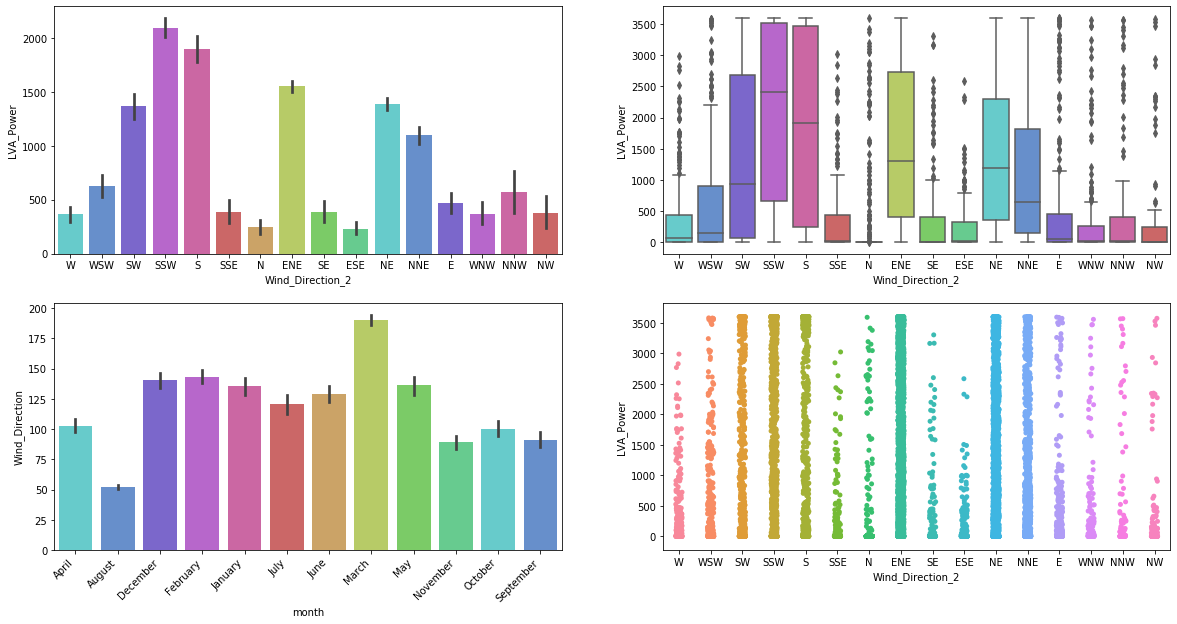

In [30]:
plt.subplots(figsize =(20, 10))

plt.subplot(2, 2, 1)
sns.barplot(x="Wind_Direction_2", y="LVA_Power", data=ts_hour, palette = mycols)

plt.subplot(2, 2, 2)
sns.boxplot(x="Wind_Direction_2", y="LVA_Power", data=ts_hour, palette = mycols)

plt.subplot(2, 2, 3)
sns.barplot(x="month", y="Wind_Direction", data=ts_hour, palette = mycols)
plt.xticks(rotation=45, horizontalalignment='right')
# g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.subplot(2, 2, 4)
sns.stripplot(x="Wind_Direction_2", y="LVA_Power", data=ts_hour, size = 5, jitter = True)

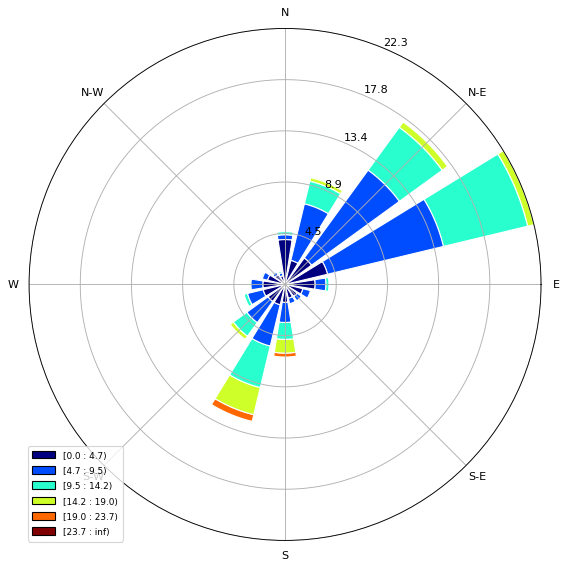

In [31]:
ax = WindroseAxes.from_ax()
ax.bar(ts_hour['Wind_Direction'], ts_hour['WindSpeed'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
#plt.show()

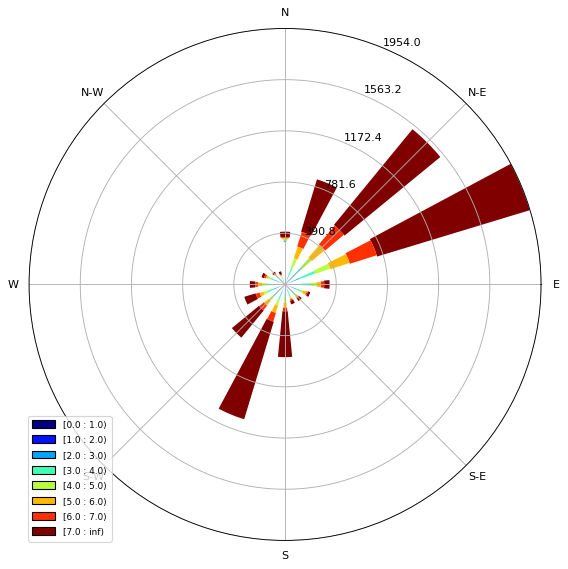

In [32]:
ax = WindroseAxes.from_ax()
ax.box(ts_hour['Wind_Direction'], ts_hour['WindSpeed'], bins=np.arange(0, 8, 1))
ax.set_legend()
#plt.show()

https://en.wikipedia.org/wiki/Wind_power

http://www.sc.ehu.es/sbweb/fisica3/datos/viento/energia.html

https://www.wind-energy-the-facts.org/detailed-loss-factors.html

https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

#### Power Generated

 In the previous section we have seen what is the energy contained in a mass of
moving air. Now, the fulfillment of the conservation equation of the mass means
that not all that power available in the air can be used.

 In addition to the characteristics of the wind, the usable power also depends on the
operating characteristics of the machine. It will also be necessary to consider the
mechanical losses in the transmission and the electrical efficiency of the generator.
These factors will be taken into account separately.

 The power coefficient of a wind turbine is defined as the fraction of power
contained in the incident wind that is actually captured by the wind turbine.
It is a measure of the efficiency of the machine.

\begin{equation}
E = \frac{\rho Av^3}{2}
\end{equation}
 
Where: Pd: available power
* ρ: wind density
* A: area exposed to incident wind
* V: incident wind speed.

#### suitable wind speed

Wind turbines start operating when the wind reaches a speed of 3 to 4 meters per second, and reaches maximum electricity production with a wind of about 13 to 14 meters per second. If the wind is very strong, for example 25 meters per second as average speed for 10 minutes, the wind turbines stop for safety reasons.

Therefore we can conclude:

* **3.5 m/s<**: The turbines do not have enough wind to operate, or the speed is so low that its operation is not economically viable.
* **3.5 - 14.0 m/s**: Within this speed range, the turbine generates maximum power.
* **14.0 - 25.0 m/s**: generates the maximum power, equal to the previous range, although the wind speed increases.
* **>25.0 m/s**: The turbine stops for safety reasons and does not produce energy.

#### Wind Farm Energy Loss Factors
When WFDTs have been used to predict the output of a wind farm, it is necessary to estimate or calculate a range of potential sources of energy loss.  There is considered to be six main sources of energy loss for wind farms, each of which may be subdivided into more detailed loss factors:

* the wake effect;
* availability;
* electrical efficiency;
* turbine performance;
* environmental losses; and
* curtailments.

Loss is difference between the Teorical Powercurve and ActivePower.

In [33]:
powers = []

for i in range(0,110,10):
    
    up = i

    ft = (ts_hour['WindSpeed'] <= 25) & (ts_hour['WindSpeed'] >= 3.5) & (ts_hour['LVA_Power'] <= up)

    no_service = ts_hour[ft]
    
    powers.append(no_service['TPC_KWh'].sum())

# sns.lineplot(x = range(0,110,10), y = potencias)

# filtrando por fuera de servicio

ft = (ts_hour['WindSpeed'] <= 25) & (ts_hour['WindSpeed'] >= 3.5) & (ts_hour['LVA_Power'] <= 0)

no_service = ts_hour[ft]

no_service['Delta_Prod'] = no_service['TPC_KWh'] - no_service['LVA_Power']
    
no_service_gb = no_service.loc[:,['month','TPC_KWh','Delta_Prod']].groupby('month').sum()

no_service_gb['TPC_KWh'] = no_service_gb['TPC_KWh']/1000

no_service_gb['Delta_Prod'] = no_service_gb['Delta_Prod']/1000


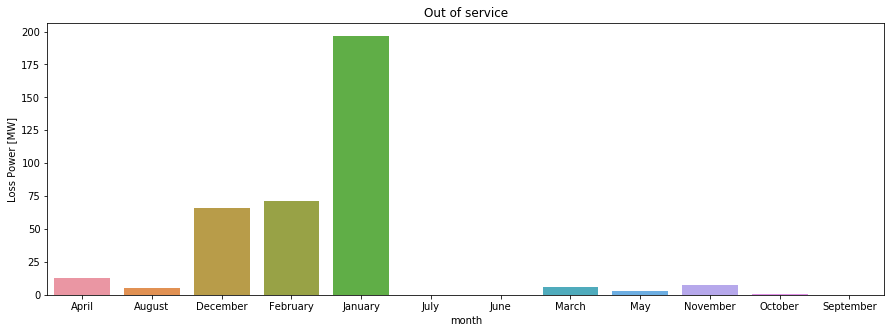

In [34]:
plt.figure(figsize =(15,5))
sns.barplot(x = no_service_gb.index, y = 'TPC_KWh', data = no_service_gb)
plt.ylabel('Loss Power [MW]')
plt.title('Out of service')
plt.show()

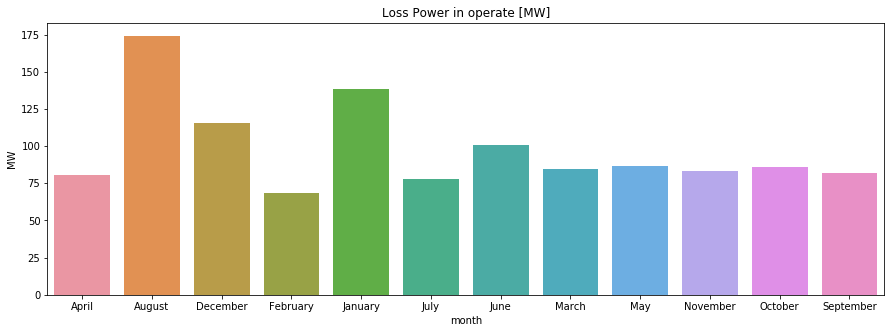

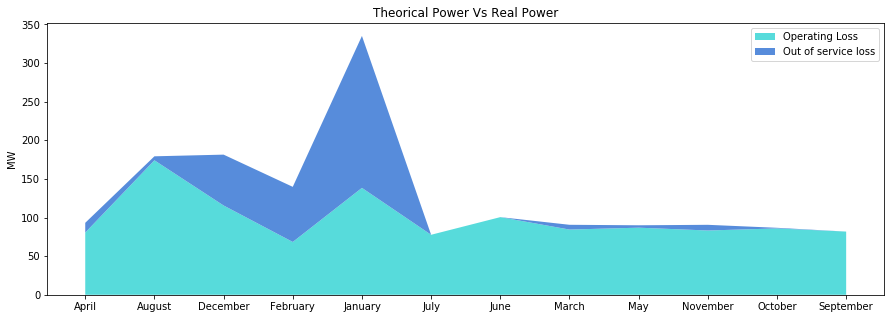

In [35]:
# hours of use with efficient wind
# WindSpeed > 3.5   WindSpeed < 25
efficient_use_hours = (ts_hour['WindSpeed'] <= 25) & (ts_hour['WindSpeed'] >= 3.5) & (ts_hour['LVA_Power'] > 0)

ts_op = ts_hour[efficient_use_hours]

ts_op['Delta_prod'] = ts_op['TPC_KWh'] - ts_op['LVA_Power']

ts_op_gb = ts_op.loc[:,['month','Delta_prod']].groupby('month').sum()

ts_op_gb['Delta_prod'] = ts_op_gb['Delta_prod']/1000

plt.figure(figsize =(15,5))
sns.barplot(x = ts_op_gb.index, y = 'Delta_prod', data = ts_op_gb)
plt.title('Loss Power in operate [MW]')
plt.ylabel('MW')
plt.show()

# Composicion de pérdidas

total_loss = ts_op_gb['Delta_prod'] + no_service_gb['Delta_Prod'] 

plt.figure(figsize =(15,5))
plt.stackplot(total_loss.index, [ts_op_gb['Delta_prod'],no_service_gb['Delta_Prod']],
              labels = ['Operating Loss', 'Out of service loss'])
plt.title('Theorical Power Vs Real Power')
plt.ylabel('MW')
plt.legend()
plt.show()

# Modeling

In [36]:
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split

from scipy.stats import skew, boxcox
from scipy.stats import norm

# sklearn preprocessing for dealing with categorical variables
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [37]:
wt_data.head()

,DateTime,LVA_Power,WindSpeed,TPC_KWh,Wind_Direction
0,2018-01-01 00:00:00,380.047791,5.311336,416.328918,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917542,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900024,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127563,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [38]:
wt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DateTime        50530 non-null  datetime64[ns]
 1   LVA_Power       50530 non-null  float32       
 2   WindSpeed       50530 non-null  float32       
 3   TPC_KWh         50530 non-null  float32       
 4   Wind_Direction  50530 non-null  float32       
dtypes: datetime64[ns](1), float32(4)
memory usage: 1.2 MB


In [39]:
#wt_data["Wind_Direction"] = wt_data["Wind_Direction"].apply(degToCompass)
#wt_data.head()

In [40]:
 #wt_data['Wind_Direction'] = wt_data['Wind_Direction'].astype('category')

In [41]:
# create a difference transform of the dataset
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return numpy.array(diff)

In [42]:
size = int(wt_data.shape[0] * 0.66)
data_a, validation = wt_data[0:size], wt_data[size:]

#data_a, validation = train_test_split(wt_data, test_size=0.3, random_state=8)

data = data_a.copy() # copy of original data(train+test)

# train_a, test_a = train_test_split(data, test_size=0.3, random_state=8)
# split dataset

size = int(data.shape[0] * 0.66)
train_a, test_a = data[0:size], data[size:]

train = train_a.copy() # Copy of original train
test = test_a.copy()   # Copy of original test

print('Original size:      ', wt_data.shape)
print('validation size:  ', validation.shape)
print('data size:       ', data.shape)
print('train size:      ', train.shape)
print('test size:        ', test.shape)

Original size:       (50530, 5)
validation size:   (17181, 5)
data size:        (33349, 5)
train size:       (22010, 5)
test size:         (11339, 5)


In [43]:
train.head()

,DateTime,LVA_Power,WindSpeed,TPC_KWh,Wind_Direction
0,2018-01-01 00:00:00,380.047791,5.311336,416.328918,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917542,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900024,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127563,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [44]:
train_missing_values = missing_values_table(train)
train_missing_values

,Missing Values,% of Total Values


In [45]:
test_missing_values = missing_values_table(test)
test_missing_values

,Missing Values,% of Total Values


### Target: LVA_Power

In [46]:
train.LVA_Power.isnull().sum()

0

In [47]:
train['LVA_Power'].describe()

count    22010.000000
mean      1255.720459
std       1360.713745
min         -2.471405
25%          0.000000
50%        637.352753
75%       2508.399231
max       3605.758057
Name: LVA_Power, dtype: float64

In [48]:
print('unique values in LVA_Power: ', train.LVA_Power.nunique())

unique values in LVA_Power:  15948


In [49]:
#Imports:

# Algorithms used for modeling
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
print('Algorithm packages imported!')

# Pipeline and scaling preprocessing will be used for models that are sensitive
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.feature_selection import chi2
print('Pipeline and preprocessing packages imported!')

# Model selection packages used for sampling dataset and optimising parameters
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
print('Model selection packages imported!')


Algorithm packages imported!
Pipeline and preprocessing packages imported!
Model selection packages imported!


### score

In [50]:
# Listado de métricas
from sklearn.metrics import SCORERS
print(SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])


In [51]:
models_cv_results = pd.DataFrame(columns=['name', 'model', 'R2_train', 'R2_test', 'nMSE_train', 'nMSE_test'])

def model_prueba(X_prueba, y_prueba):
    
    pipelines = []
    pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
    pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
    pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
    pipelines.append(('ScaledLGBMR',Pipeline([('Scaler', StandardScaler()),('LGBMR', LGBMRegressor(n_estimators=1000))])))
    pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
    pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
    pipelines.append(('ScalerXGBR', Pipeline([('Scaler', StandardScaler()), ('XGBR', XGBRegressor(seed=2))])))
    pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())]))) 
    pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
    
    for name, model in pipelines:
        scores = cross_validate(model, X_prueba, y_prueba, cv=4, 
                                scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)
        
        R2_train = scores['train_r2'].mean().round(5)
        R2_test = scores['test_r2'].mean().round(5)
        nMSE_train = scores['train_neg_mean_squared_error'].mean().round(5)
        nMSE_test = scores['test_neg_mean_squared_error'].mean().round(5)
        
        r = models_cv_results.shape[0]
        models_cv_results.loc[r] = [name, model, R2_train, R2_test, nMSE_train, nMSE_test]
        print(models_cv_results.loc[r])

    return models_cv_results

#### Split dataset

In [52]:
X_train = train.copy()
y_train = X_train['LVA_Power'].values
X_train = X_train.drop('LVA_Power', axis = 1)

X_test = test.copy()
y_test = X_test['LVA_Power'].values
X_test = X_test.drop('LVA_Power', axis = 1)

In [53]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test:  ', X_test.shape)
print('y_test:  ', y_test.shape)

X_train:  (22010, 4)
y_train:  (22010,)
X_test:   (11339, 4)
y_test:   (11339,)


In [54]:
X_train.head()

,DateTime,WindSpeed,TPC_KWh,Wind_Direction
0,2018-01-01 00:00:00,5.311336,416.328918,259.994904
1,2018-01-01 00:10:00,5.672167,519.917542,268.641113
2,2018-01-01 00:20:00,5.216037,390.900024,272.564789
3,2018-01-01 00:30:00,5.659674,516.127563,271.258087
4,2018-01-01 00:40:00,5.577941,491.702972,265.674286


In [55]:
X_train.drop('DateTime', axis=1, inplace=True)

In [56]:
%%time
models_cv_results = model_prueba(X_train, y_train)
models_cv_results

name                                                   ScaledLR
model         (StandardScaler(copy=True, with_mean=True, wit...
R2_train                                                0.86391
R2_test                                                 0.85492
nMSE_train                                              -252470
nMSE_test                                               -284271
Name: 0, dtype: object
name                                                ScaledLASSO
model         (StandardScaler(copy=True, with_mean=True, wit...
R2_train                                                0.86391
R2_test                                                 0.85501
nMSE_train                                              -252472
nMSE_test                                               -284206
Name: 1, dtype: object
name                                                   ScaledEN
model         (StandardScaler(copy=True, with_mean=True, wit...
R2_train                                                0.

,name,model,R2_train,R2_test,nMSE_train,nMSE_test
0,ScaledLR,"(StandardScaler(copy=True, with_mean=True, wit...",0.86391,0.85492,-252469.90820,-284270.53125
1,ScaledLASSO,"(StandardScaler(copy=True, with_mean=True, wit...",0.86391,0.85501,-252471.91016,-284206.15723
2,ScaledEN,"(StandardScaler(copy=True, with_mean=True, wit...",0.82045,0.80315,-331848.70703,-358505.53516
3,ScaledLGBMR,"(StandardScaler(copy=True, with_mean=True, wit...",0.94509,0.78462,-101816.67410,-372581.77254
4,ScaledCART,"(StandardScaler(copy=True, with_mean=True, wit...",1.00000,0.68208,-0.00000,-513750.34315
5,ScaledGBM,"(StandardScaler(copy=True, with_mean=True, wit...",0.90405,0.81525,-177818.28469,-330028.50862
6,ScalerXGBR,"(StandardScaler(copy=True, with_mean=True, wit...",0.95598,0.79058,-82045.01367,-367165.01953
7,ScaledKNN,"(StandardScaler(copy=True, with_mean=True, wit...",0.92212,0.78632,-144156.93750,-369634.39062
8,ScaledSVM,"(StandardScaler(copy=True, with_mean=True, wit...",0.85672,0.84633,-264827.90055,-299819.07925


In [57]:
from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval

In [58]:
 # Define searched space
hyper_space = {'n_estimators': 1000 + hp.randint('n_estimators', 1000),
               'max_depth':  hp.choice('max_depth', [3, 5, 8, 12]),
               'num_leaves': hp.choice('num_leaves', [7, 25, 50, 800]),
               'subsample': hp.uniform('subsample', 0.6, 1.0)}

In [59]:
def evaluate(params, X, y):
    
    # Initilize instance of estimator
    est = LGBMRegressor(boosting_type='gbdt', n_jobs=-1, random_state=2018)
    
    # Set params
    est.set_params(**params)
    
    # Calc CV score
    scores = cross_val_score(estimator=est, X=X, y=y, scoring='r2', cv=4)
    score = np.mean(scores)
 
    return score
 
# Objective minizmied 
hyperopt_objective = lambda params: (-1.0) * evaluate(params, X_train, y_train)

In [60]:
# Trail
trials = Trials()
 
# Set algoritm parameters
algo = partial(tpe.suggest, n_startup_jobs=20, gamma=0.25, n_EI_candidates=24)
 
# Fit Tree Parzen Estimator
best_vals = fmin(hyperopt_objective, space=hyper_space,
                 algo=algo, max_evals=60, trials=trials,
                 rstate=np.random.RandomState(seed=2018))
 
# Print best parameters
best_params = space_eval(hyper_space, best_vals)
print("BEST PARAMETERS: " + str(best_params))
 
# Print best CV score
scores = [-trial['result']['loss'] for trial in trials.trials]
print("BEST CV SCORE: " + str(np.max(scores)))
 
# Print execution time
tdiff = trials.trials[-1]['book_time'] - trials.trials[0]['book_time']
print("ELAPSED TIME: " + str(tdiff.total_seconds() / 60))


100%|███████████████████████████████████████████████| 60/60 [03:46<00:00,  3.78s/trial, best loss: -0.8050072546094686]
BEST PARAMETERS: {'max_depth': 3, 'n_estimators': 1043, 'num_leaves': 800, 'subsample': 0.755428025562507}
BEST CV SCORE: 0.8050072546094686
ELAPSED TIME: 3.666


In [61]:
from sklearn.metrics import r2_score

X_test.drop('DateTime', axis=1, inplace=True)

est = LGBMRegressor(boosting_type='gbdt', n_jobs=-1, random_state=2018)

# Set params
est.set_params(**best_params)
 
# Fit    
est.fit(X_train, y_train)
y_pred = est.predict(X_test)
 
# Predict
score = r2_score(y_test, y_pred)
print("R2 SCORE ON TEST DATA: {}".format(score))

R2 SCORE ON TEST DATA: 0.9405449307894191


In [62]:
## Deep Neural Network
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import metrics,regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [63]:
wt_data.head()

,DateTime,LVA_Power,WindSpeed,TPC_KWh,Wind_Direction
0,2018-01-01 00:00:00,380.047791,5.311336,416.328918,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917542,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900024,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127563,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [64]:
for i in range(0,wt_data.shape[1]):
    print('{}: Max: {} Min: {}'.format(wt_data.columns[i],wt_data.iloc[:,i].max(),wt_data.iloc[:,i].min()))

DateTime: Max: 2018-12-31 23:50:00 Min: 2018-01-01 00:00:00
LVA_Power: Max: 3618.73291015625 Min: -2.471405029296875
WindSpeed: Max: 25.206010818481445 Min: 0.0
TPC_KWh: Max: 3600.0 Min: 0.0
Wind_Direction: Max: 359.9975891113281 Min: 0.0


In [65]:
# Define max-min values used during normalisation process
data = wt_data.copy()

max_values = {"WindSpeed": 26,
              "TPC_KWh": 3600,
              "Wind_Direction": 360}

min_values = {"WindSpeed": 0,
              "TPC_KWh": 0,
              "Wind_Direction": 0}

 # Normalise the data using Min-Max normalisation
for key in data.keys()[2:]:
    data[key] = data[key].apply(lambda x: (x - min_values[key]) / (max_values[key] - min_values[key]))

In [66]:
# Check
wt_data.head()

,DateTime,LVA_Power,WindSpeed,TPC_KWh,Wind_Direction
0,2018-01-01 00:00:00,380.047791,5.311336,416.328918,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917542,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900024,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127563,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [67]:
columns_X = ['WindSpeed','TPC_KWh','Wind_Direction']
columns_Y = ['LVA_Power']

In [68]:
indices = np.random.permutation(wt_data.shape[0])

# DNN improves with performance using more data, so we split the data using 80/10/10 proportion
#The training data consist of "the sample of data used to fit our model". 
#The validation data are "the sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters". 
#The test data are "The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset". 

train_size = int(0.80 * data.shape[0])
val_size = int(0.1 * data.shape[0])
test_size = int(0.1 * data.shape[0])

# Create index of each set of data 
training_idx, val_idx, test_idx = indices[:train_size], indices[train_size:(train_size+val_size)],indices[(train_size+val_size):]

# Divide the data according to the index
ann_train = data.iloc[training_idx,:][columns_X]
ann_val = data.iloc[val_idx,:][columns_X]
ann_test = data.iloc[test_idx,:][columns_X]

y_train = data.iloc[training_idx,:][columns_Y]
y_val = data.iloc[val_idx,:][columns_Y]
y_test = data.iloc[test_idx,:][columns_Y]

In [71]:
L2_REG = 0
visible = Input(shape=(3,))

X = Dense(8, activation='relu',kernel_initializer = 'random_normal',kernel_regularizer=regularizers.l2(L2_REG))(visible)
X = Dense(6, activation='relu',kernel_initializer = 'random_normal',kernel_regularizer=regularizers.l2(L2_REG))(X)
X = Dense(4, activation='relu',kernel_initializer = 'random_normal',kernel_regularizer=regularizers.l2(L2_REG))(X)

output =  Dense(1, activation='relu')(X)
model =   Model(inputs=visible, outputs=output)


adam = Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)
model.compile(loss= 'mean_squared_error' , optimizer= adam )
    

filepath="models/{epoch:02d}.hdf5"


# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 50)

In [72]:
history = model.fit([ann_train], y_train, batch_size = 100 , epochs = 60000 ,callbacks = [es] ,verbose=1,validation_data = ([ann_val], y_val)) 

Train on 40424 samples, validate on 5053 samples
Epoch 1/60000
40424/40424 [==============================] - 0s 11us/sample - loss: 1271456.6245 - val_loss: 156448.8282
Epoch 2/60000
40424/40424 [==============================] - 0s 8us/sample - loss: 163980.8931 - val_loss: 143193.1529
Epoch 3/60000
40424/40424 [==============================] - 0s 8us/sample - loss: 161723.0712 - val_loss: 143223.9152
Epoch 4/60000
40424/40424 [==============================] - 0s 8us/sample - loss: 161778.9500 - val_loss: 144239.1006
Epoch 5/60000
40424/40424 [==============================] - 0s 8us/sample - loss: 161704.7151 - val_loss: 143125.1451
Epoch 6/60000
40424/40424 [==============================] - 0s 7us/sample - loss: 161510.9338 - val_loss: 144588.2291
Epoch 7/60000
40424/40424 [==============================] - 0s 8us/sample - loss: 161149.3106 - val_loss: 144704.7117
Epoch 8/60000
40424/40424 [==============================] - 0s 8us/sample - loss: 161225.8060 - val_loss: 142402.30

Epoch 67/60000
40424/40424 [==============================] - 0s 8us/sample - loss: 155506.3265 - val_loss: 139549.2749
Epoch 68/60000
40424/40424 [==============================] - 0s 7us/sample - loss: 155610.2216 - val_loss: 137977.4866
Epoch 69/60000
40424/40424 [==============================] - 0s 7us/sample - loss: 155535.5579 - val_loss: 138265.3420
Epoch 70/60000
40424/40424 [==============================] - 0s 8us/sample - loss: 155836.5604 - val_loss: 140294.4003
Epoch 71/60000
40424/40424 [==============================] - 0s 7us/sample - loss: 155513.5566 - val_loss: 138202.9260
Epoch 72/60000
40424/40424 [==============================] - 0s 7us/sample - loss: 155705.5745 - val_loss: 139041.5455
Epoch 73/60000
40424/40424 [==============================] - 0s 7us/sample - loss: 155554.9612 - val_loss: 137919.5725
Epoch 74/60000
40424/40424 [==============================] - 0s 7us/sample - loss: 156301.6032 - val_loss: 138403.0063
Epoch 75/60000
40424/40424 [============

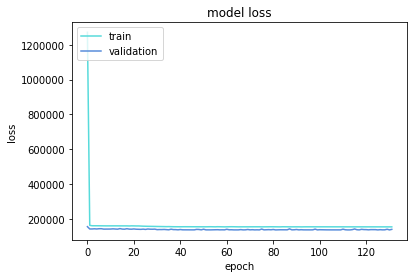

In [73]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [74]:
y_pred = model.predict(ann_test, verbose=0).reshape(y_test.shape[0],)
# Predict
score = r2_score(y_test, y_pred)
print("R2 SCORE ON TEST DATA: {}".format(score))

R2 SCORE ON TEST DATA: 0.9119917160937839


# Another Approach: 
## Predict 3-hours-ahead using sequences and historical data
* Using ARIMA

In [79]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

X = wt_data.LVA_Power.values
forecast_horizon = 3

size = int(len(X) * 0.95)
print(X[size:len(X)].shape)
train, test = X[0:size], X[size:(size+forecast_horizon)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
    
error = mean_squared_error(test, predictions)
r2 = r2_score(y_test, y_pred)
print('R2 score: %.3f' % r2)
print('Test MSE: %.3f' % error)

(2527,)
predicted=653.702647, expected=797.071716
predicted=791.372941, expected=688.739502
predicted=662.150563, expected=661.102478
R2 score: 0.912
Test MSE: 10363.137


# Futher Improvements
* Use historical data with exogenous input to predict 3-hours-ahead
* Use wavelet transform to descompose input data into differents sequences
* Try another approach using LSTM, CNN-LSTM and other DL architectures